## 0) 라이브러리 import 및 데이터 경로 설정

In [8]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
train_data.shape

(150000, 3)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 1) 데이터 준비
- tokenizer는 ```Mecab```을 사용
- 불용어도 간단하게 정의 후 전처리에 사용
- ```word_to_index```생성

In [4]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

## 2) index_to_word생성
- ```word_to_index```를 활용해서 새로운 ```index_to_word```생성
- 그외에 인덱스를 입력하면 단어로 리턴해주는 함수, 단어를 입력하면 인덱스로 리턴해주는 함수를 정의

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [9]:
X_test.shape

(49157, 41)

## 4) validation set 구성 및 모델선정

### 4-1) validation set 구성

In [10]:
len(X_train)

146182

In [11]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


### 4-2) model선정
- 같은 파라미터로 3가지 모델을 학습
    1. 1-D CNN
    2. LSTM
    3. GlobalMaxPooling1D
- 이후에 가장 성능이 좋은 모델 선택 후 파라미터 튜닝을 수행

In [12]:
# 세가지 모델을 평가할 때, 파라미터는 고정으로 사용
vocab_size = len(index_to_word)
word_vector_dim = 300

#### 1-D CNN

In [22]:
# CNN

CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 256)         537856    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9       

#### LSTM

In [19]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 9888      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


#### GlobalMaxPooling1D

In [20]:
# GlobalMaxPooling1D

GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


#### 3가지 모델을 같은 조건에서 학습 후 결과 확인

In [23]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [25]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results

----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 13s 51ms/step - loss: 0.4018 - accuracy: 0.8105 - val_loss: 0.3248 - val_accuracy: 0.8590
Epoch 2/20
247/247 [==============================] - 8s 33ms/step - loss: 0.2752 - accuracy: 0.8850 - val_loss: 0.3202 - val_accuracy: 0.8630
Epoch 3/20
247/247 [==============================] - 8s 33ms/step - loss: 0.1844 - accuracy: 0.9296 - val_loss: 0.3651 - val_accuracy: 0.8610
Epoch 4/20
247/247 [==============================] - 8s 33ms/step - loss: 0.1028 - accuracy: 0.9638 - val_loss: 0.4572 - val_accuracy: 0.8534
Epoch 5/20
247/247 [==============================] - 8s 33ms/step - loss: 0.0566 - accuracy: 0.9811 - val_loss: 0.5419 - val_accuracy: 0.8494
Epoch 6/20
247/247 [==============================] - 8s 33ms/step - loss: 0.0370 - accuracy: 0.9876 - val_loss: 0.6719 - val_accuracy: 0.8503
Epoch 7/20
247/247 [==============================] - 8s 33ms/step - loss: 0.0

In [43]:
for name, [_, acc] in sorted(model_result.items(), key=lambda x : x[1][1], reverse=True) :
    print(name,'\t',acc)

LSTM 	 0.842443585395813
CNN 	 0.8413450717926025
GMP 	 0.8402465581893921


## 5) 모델 훈련
- 위의 모델 중에서 LSTM의 성능이 가장 좋았다.
- 모델을 훈련하기 전에 먼저 성능을 올릴 수 있는 최적의 하이퍼파라미터를 찾아본다.

#### 최적의 모델 만들기
- LSTM모델 앞에 CNN을 추가도 해보았고, LSTM을 추가도 해보았다.
    - CNN의 경우는 추가를 하면 성능이 더 나빴다.
    - LSTM층을 하나 더 추가할 경우 결과는 크게 달라지지 않았지만 학습 곡선이 다르게 나타나는 것을 알 수 있었다.
- 간단하게 LSTM 레이어 하나만을 사용해서 하이퍼파라미터를 튜닝해보도록 하였다.
    - ```word_vector_dim``` 을 늘려가면서 성능이 점점 더 좋아지는 것을 알 수 있었다.
        - 1000
    - ```LSTM``` 레이어의 벡터 차원수를 기존에 8에서 128까지 늘렸다.
        - input dimension이 1000개에 반해 128개의 차원은 여전히 부족하지 않을까?
    - ```Overfitting```이 자주 발생하여서 ```LSTM```의 인자로 ```Dropout```도 추가하였다.

In [81]:
word_vector_dim = 1000  # 워드 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# CNN을 추가했을 때
# model.add(keras.layers.Conv1D(8, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D())
# LSTM 레이어를 두개로 학습했을 때
# model.add(keras.layers.LSTM(256, dropout=0.7, return_sequences=True))
model.add(keras.layers.LSTM(128, dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 이진분류

model.summary()

이전에 20번 epoch을 돌리는 동안 ```validation loss```값이 오르는 것을 확인할 수 있었다.(**Overfitting 발생**)  

그렇게 때문에 ```callback```의 ```EarlyStopping```을 사용하였고 최적의 모델을 저장하기 위해서 ```ModelCheckpoint```를 사용하였다.

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

```optimizer```에서 사용하는 ```Adam```에도 ```learning rate```를 조절해주었다.  
이전에 세가지 모델을 학습시켜보았을 때 여러번 학습이 진행되기 전에 **Overfitting**이 발생하였기 때문에 학습률을 낮추었다.
추가적으로 배치사이즈도 더 작게 설정하였다.

In [99]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.7802
Epoch 00001: val_accuracy improved from -inf to 0.84590, saving model to model.h5
986/986 [==============================] - 72s 73ms/step - loss: 0.4350 - accuracy: 0.7802 - val_loss: 0.3492 - val_accuracy: 0.8459
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8618
Epoch 00002: val_accuracy improved from 0.84590 to 0.85915, saving model to model.h5
986/986 [==============================] - 71s 72ms/step - loss: 0.3221 - accuracy: 0.8618 - val_loss: 0.3339 - val_accuracy: 0.8591
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.8783
Epoch 00003: val_accuracy improved from 0.85915 to 0.86455, saving model to model.h5
986/986 [==============================] - 71s 72ms/step - loss: 0.2865 - accuracy: 0.8783 - val_loss: 0.3230 - val_accuracy: 0.8645
Epoch 4/20
986/986 [==============================] - ETA: 0s

In [100]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3759 - accuracy: 0.8600
[0.3759104311466217, 0.8600403070449829]


이렇게 학습시킨 결과 ```0.842```에서 ```0.86```까지 정확도가 상승하였다.

## 6) Loss, Accuracy 그래프 시각화


In [101]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


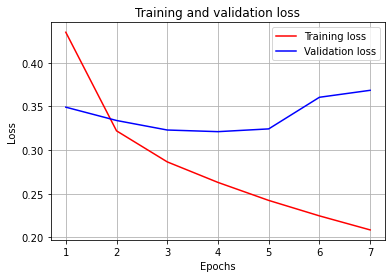

In [102]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [103]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)


위에서 학습시킨 ```word2vector```를 저장시킨다.

In [104]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

```gensim```을 사용해서 학습시킨 ```word2vector```를 사용해서 ```대박```이라는 단어와 연관성이 있는 단어들을 뽑아보았다.  
영화리뷰라고 생각해보았을 때, 긍정적인 평가들이 나오는 것을 확인할 수 있다.

In [105]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['대박']
# vector

In [106]:
word_vectors.similar_by_word("대박")

[('슬퍼요', 0.5566833019256592),
 ('괜춘', 0.5530017614364624),
 ('최고', 0.5513213872909546),
 ('진진', 0.5508062839508057),
 ('먹먹', 0.544702410697937),
 ('습니당', 0.5446221828460693),
 ('즐겼', 0.5427483320236206),
 ('담백', 0.5413448214530945),
 ('여신', 0.5374443531036377),
 ('최상', 0.5369764566421509)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
- [pre-trained word vectors](https://github.com/Kyubyong/wordvectors)
    - 한국어를 다운로드
    - 위키피디아를 통해서 만든 Word2Vec를 만든 것 같다.

In [14]:
import os

In [15]:
os.listdir('sentiment_classification/')

['word2vec.txt',
 'kowiki-20200820-pages-articles-multistream-index.txt.bz2',
 'ratings_test.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'ko.tsv',
 'ko.zip',
 'kowiki-20200820-pages-articles-multistream.xml.bz2',
 'wordvectors',
 'ko.bin',
 'ratings_train.txt']

In [16]:
 os.getenv('HOME')+'/aiffel/sentiment_classification/ko.tsv'

'/home/aiffel0042/aiffel/sentiment_classification/ko.tsv'

In [10]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

기존의 코드는 다음과 같다.  
```python
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
```
하지만 ```bin```파일로 저장되어 있는 ```word2vec```를 불러오기 위해서는 아래와 같이 사용하면 된다.

In [11]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_file_path)

In [19]:
vector = word2vec['대박']
vector

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.12250227, -0.26166117,  0.1601894 ,  0.24988233, -0.19694664,
        0.20742898,  0.23358916, -0.08032743,  0.07419734,  0.28976992,
        0.05920417, -0.24217431,  0.42650384,  0.37083197,  0.01488842,
       -0.15399031,  0.21594983,  0.16782928,  0.04716487, -0.3933347 ,
        0.06105555, -0.13588727, -0.0257909 , -0.06074918,  0.04168789,
        0.34588724,  0.24693313, -0.05122459,  0.16371667,  0.05747311,
       -0.12627307, -0.16464052, -0.29741055,  0.17121391, -0.24180788,
       -0.28056645, -0.06616814,  0.15681611,  0.20206362, -0.1660444 ,
        0.00203782, -0.2563252 , -0.24074501, -0.63730514,  0.35244125,
        0.05436644, -0.14913762, -0.06556495, -0.05610788,  0.11254067,
       -0.09251513, -0.28059378,  0.07197419,  0.11595767,  0.15117767,
       -0.00541334, -0.128903  ,  0.04034068, -0.22690742,  0.00775241,
        0.16708778,  0.10937496, -0.17221814,  0.04758313,  0.321897  ,
        0.0646909 ,  0.292136  , -0.07984147,  0.09785581,  0.18

위에서 불러온 ```word2vec```를 사용해서 ```embedding_matrix```를 생성해준다.

In [21]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


위에서 만든 임베딩을 여기서 학습하는데 활용한다.  
모델은 위에서 사용한것과 동일하게 ```LSTM```을 사용하였고 ```LSTM``` 레이어의 차원도 ```128```로 설정하였다.  
여기서 ```Embedding``` 레이어에 ```embedding_matrix```로 초기화를 해주었기 때문에 ```word_vector_dim```과 같은 경우는 기존에 초기화 되어있는 임베딩의 차원인 200으로 줘야한다.

In [28]:
from keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [29]:
# 학습의 진행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
984/986 [============================>.] - ETA: 0s - loss: 0.5027 - accuracy: 0.7323
Epoch 00001: val_accuracy did not improve from 0.86890
986/986 [==============================] - 18s 19ms/step - loss: 0.5025 - accuracy: 0.7324 - val_loss: 0.3663 - val_accuracy: 0.8371
Epoch 2/20
984/986 [============================>.] - ETA: 0s - loss: 0.3299 - accuracy: 0.8577
Epoch 00002: val_accuracy did not improve from 0.86890
986/986 [==============================] - 18s 19ms/step - loss: 0.3298 - accuracy: 0.8578 - val_loss: 0.3249 - val_accuracy: 0.8609
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2834 - accuracy: 0.8815
Epoch 00003: val_accuracy did not improve from 0.86890
986/986 [==============================] - 18s 19ms/step - loss: 0.2834 - accuracy: 0.8815 - val_loss: 0.3204 - val_accuracy: 0.8655
Epoch 4/20
986/986 [==============================] - ETA: 0s - loss: 0.2500 - accuracy: 0.8954
Epoch 00004: val_accuracy did not improve from 0.868

In [30]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4221 - accuracy: 0.8628
[0.4220728278160095, 0.8628069162368774]


오!!!!! 놀랍게도 ```validation accuracy```가 **```0.002```** 증가했다.  
그래프로 시각화도 해보았다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


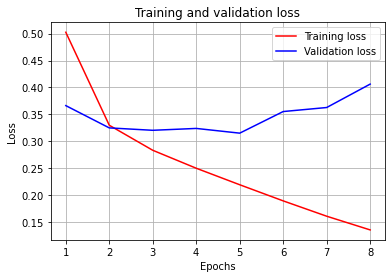

In [31]:
history_dict = history.history
print(history_dict.keys())

# 시각화를 시도한다.
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 정리

- 세가지의 모델을 사용해보았다.
    1. ```1D CNN``` : ```0.8413```
    2. ```LSTM``` : ```0.8424```
    3. ```GlobalMaxPooling1D``` : ```0.8402```
- 그 중에서 제일 좋은 LSTM으로 선택, 모델구조 찾기
    - 하이퍼파라미터를 튜닝하기 전에 모델구조에 대해서 생각해 보았다.
        1. CNN 1D -> LSTM
        2. LSTM -> LSTM
        3. LSTM 단일 레이어
    - 하지만 CNN을 추가한 경우 생각보다 점수가 낮게 나오고 LSTM 레이어를 두개를 사용해도 성능은 나아지지 않았다.
- 하이퍼파라미터 설정
    - ```word_vector_dim = 1000```
    - LSTM 레이어의 차원 수 = ```128```, ```dropout = 0.7``` 적용
    - ```Adam``` optimizer의 ```learning rate = 0.0005```
    - ```batch_size = 128```
- Callback 함수 사용
    - ```EearlyStopping```
    - ```Checkpoint```
- 정확도는 ```0.8413``` -> ```0.86``` 으로 약 2퍼센트 성능 향상
---

- 학습한 임베딩 결과 확인
    - '대박'이라는 단어를 통해서 유사단어를 찾아 보았다.
    - 대부분 영화리뷰로써 긍정적인 평가를 한 결과가 나왔다.
![image](https://user-images.githubusercontent.com/48716219/91934045-42e38000-ed25-11ea-8d21-6725bd6cd550.png)


---

- 사전 학습된 워드임베딩적용 후 같은 파라미터로 학습
    - 정확도 ```0.86``` -> ```0.862``` 로 약 0.2퍼센트 성능 향상